# Project 4A - Spray Analysis

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon


import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

MAPBOX_TOKEN = 'pk.eyJ1IjoiZmNvbWJlbGxlczE4IiwiYSI6ImNsYmZ0MGNhdTA0cmIzdnBmejk0azF6ZzgifQ.b0AOPQEYA4koQBIPbkXeAA'

Importing relevant files and geographical maps

In [2]:
weather = pd.read_csv('data/datasets/weather.csv', parse_dates=True)
train = pd.read_csv('data/datasets/train.csv', parse_dates=True)
test = pd.read_csv('data/datasets/test.csv', parse_dates=True)
spray = pd.read_csv('data/datasets/spray_clean.csv', parse_dates=True)

chicago = gpd.read_file('data/map/geo_export_c1136ecf-9473-4a42-8d0e-524480fe2323.shp')
crs = {'init': 'epsg:4326'}

Display file head and define Date format for data column

In [3]:
train.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [4]:
# Define format for date and split it

train['Date'] = pd.to_datetime(train.Date, format='%Y-%m-%d')

train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year

train['year_month'] = train['Date'].dt.strftime('%Y-%m')

In [5]:
# Display the years present in the dataset

train['year'].value_counts()

2007    3811
2013    2392
2009    2249
2011    2054
Name: year, dtype: int64

In [6]:
spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [7]:
# Define format for date and split it

spray['Date'] = pd.to_datetime(spray.Date, format='%Y-%m-%d')

spray['day'] = spray['Date'].dt.day
spray['month'] = spray['Date'].dt.month
spray['year'] = spray['Date'].dt.year

spray['year_month'] = spray['Date'].dt.strftime('%Y-%m')

For 2011, spraying was done between August and September
For 2013, spraying was done between July and September

In [8]:
spray

Date        Time   Latitude  Longitude  day  month  year  \
0     2011-08-29  6:56:58 PM  42.391623 -88.089163   29      8  2011   
1     2011-08-29  6:57:08 PM  42.391348 -88.089163   29      8  2011   
2     2011-08-29  6:57:18 PM  42.391022 -88.089157   29      8  2011   
3     2011-08-29  6:57:28 PM  42.390637 -88.089158   29      8  2011   
4     2011-08-29  6:57:38 PM  42.390410 -88.088858   29      8  2011   
...          ...         ...        ...        ...  ...    ...   ...   
14830 2013-09-05  8:34:11 PM  42.006587 -87.812355    5      9  2013   
14831 2013-09-05  8:35:01 PM  42.006192 -87.816015    5      9  2013   
14832 2013-09-05  8:35:21 PM  42.006022 -87.817392    5      9  2013   
14833 2013-09-05  8:35:31 PM  42.005453 -87.817423    5      9  2013   
14834 2013-09-05  8:35:41 PM  42.004805 -87.817460    5      9  2013   

      year_month  
0        2011-08  
1        2011-08  
2        2011-08  
3        2011-08  
4        2011-08  
...          ...  
14830    2013-09  
14831    2013-09  
14832    2013-09  
14833    2013-09  
14834    2013-09  

[14835 rows x 8 columns]

Create a new Dataframe

This new DataFrame will include the total number of mosquitos per address and the amount of time a trap has been detected as positive 

In [9]:
# New DataFrame with total number of mosquitos per address

mosquito_count = train.groupby(['Address'], as_index = False)[['NumMosquitos']].sum()
areas = train.groupby(['Address'], as_index = False)[['Latitude','Longitude']].median()
wnv = train.groupby(['Address'], as_index = False)[['WnvPresent']].sum()
y = train.groupby(['Address'], as_index = False)[['year']].median()
m = train.groupby(['Address'], as_index = False)[['month']].median()

mosquito_areas_wnv = pd.concat([mosquito_count,areas, wnv, y, m], axis = 1)
#mosquito_areas_wnv.drop('Address', axis = 1, inplace = True)

In [10]:
mosquito_areas_wnv.columns

Index(['Address', 'NumMosquitos', 'Address', 'Latitude', 'Longitude',
       'Address', 'WnvPresent', 'Address', 'year', 'Address', 'month'],
      dtype='object')

In [11]:
# Trying to remove extra address columns

#mosquito_areas_wnv.drop(mosquito_areas_wnv.columns[[2,5]], axis=1, inplace=True)

In [12]:
mosquito_areas_wnv

Address  NumMosquitos  \
0        1000 East 67th Street, Chicago, IL 60637, USA           852   
1    1000 North Central Park Avenue, Chicago, IL 60...          1802   
2    1000 South California Avenue, Chicago, IL 6061...           125   
3        1000 West 95th Street, Chicago, IL 60643, USA           185   
4    1100 North Artesian Avenue, Chicago, IL 60622,...           666   
..                                                 ...           ...   
133           South Vincennes Avenue, Chicago, IL, USA           374   
134             South Wallace Street, Chicago, IL, USA            28   
135  University of Illinois at Chicago, 1100 South ...          1685   
136                  West 37th Place, Chicago, IL, USA            47   
137          West Garfield Boulevard, Chicago, IL, USA           848   

                                               Address   Latitude  Longitude  \
0        1000 East 67th Street, Chicago, IL 60637, USA  41.773215 -87.600880   
1    1000 North Central Park Avenue, Chicago, IL 60...  41.899230 -87.716788   
2    1000 South California Avenue, Chicago, IL 6061...  41.869107 -87.696293   
3        1000 West 95th Street, Chicago, IL 60643, USA  41.721474 -87.648064   
4    1100 North Artesian Avenue, Chicago, IL 60622,...  41.903002 -87.688267   
..                                                 ...        ...        ...   
133           South Vincennes Avenue, Chicago, IL, USA  41.723195 -87.649970   
134             South Wallace Street, Chicago, IL, USA  41.753411 -87.639817   
135  University of Illinois at Chicago, 1100 South ...  41.868077 -87.666901   
136                  West 37th Place, Chicago, IL, USA  41.825902 -87.667827   
137          West Garfield Boulevard, Chicago, IL, USA  41.793818 -87.654234   

                                               Address  WnvPresent  \
0        1000 East 67th Street, Chicago, IL 60637, USA           4   
1    1000 North Central Park Avenue, Chicago, IL 60...           8   
2    1000 South California Avenue, Chicago, IL 6061...           0   
3        1000 West 95th Street, Chicago, IL 60643, USA           1   
4    1100 North Artesian Avenue, Chicago, IL 60622,...           4   
..                                                 ...         ...   
133           South Vincennes Avenue, Chicago, IL, USA           4   
134             South Wallace Street, Chicago, IL, USA           0   
135  University of Illinois at Chicago, 1100 South ...           7   
136                  West 37th Place, Chicago, IL, USA           0   
137          West Garfield Boulevard, Chicago, IL, USA           4   

                                               Address    year  \
0        1000 East 67th Street, Chicago, IL 60637, USA  2009.0   
1    1000 North Central Park Avenue, Chicago, IL 60...  2011.0   
2    1000 South California Avenue, Chicago, IL 6061...  2007.0   
3        1000 West 95th Street, Chicago, IL 60643, USA  2007.0   
4    1100 North Artesian Avenue, Chicago, IL 60622,...  2009.0   
..                                                 ...     ...   
133           South Vincennes Avenue, Chicago, IL, USA  2011.0   
134             South Wallace Street, Chicago, IL, USA  2009.0   
135  University of Illinois at Chicago, 1100 South ...  2009.0   
136                  West 37th Place, Chicago, IL, USA  2007.0   
137          West Garfield Boulevard, Chicago, IL, USA  2011.0   

                                               Address  month  
0        1000 East 67th Street, Chicago, IL 60637, USA    8.0  
1    1000 North Central Park Avenue, Chicago, IL 60...    8.0  
2    1000 South California Avenue, Chicago, IL 6061...    8.0  
3        1000 West 95th Street, Chicago, IL 60643, USA    8.0  
4    1100 North Artesian Avenue, Chicago, IL 60622,...    8.0  
..                                                 ...    ...  
133           South Vincennes Avenue, Chicago, IL, USA    8.0  
134             South Wallace Street, Chicago, IL, USA    8.5  
135  Univer

In [13]:
mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2013) & (mosquito_areas_wnv['month'] == 8),('Address', 'NumMosquitos')]

Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  \
16   1700 North Ashland Avenue, Chicago, IL 60622, USA   
19    1700 West Addison Street, Chicago, IL 60613, USA   
23     2100 North Cannon Drive, Chicago, IL 60614, USA   
54   3900 North Springfield Avenue, Chicago, IL 606...   
74       5100 West 72nd Street, Chicago, IL 60638, USA   
80     5800 North Ridge Avenue, Chicago, IL 60660, USA   
89   6200 North Mcclellan Avenue, Chicago, IL 60646...   
100   7100 North Harlem Avenue, Chicago, IL 60631, USA   

                                               Address  NumMosquitos  
16   1700 North Ashland Avenue, Chicago, IL 60622, USA           286  
19    1700 West Addison Street, Chicago, IL 60613, USA           284  
23     2100 North Cannon Drive, Chicago, IL 60614, USA           145  
54   3900 North Springfield Avenue, Chicago, IL 606...           643  
74       5100 West 72nd Street, Chicago, IL 60638, USA           215  
80     5800 North Ridge Avenue, Chicago, IL 60660, USA           521  
89   6200 North Mcclellan Avenue, Chicago, IL 60646...           375  
100   7100 North Harlem Avenue, Chicago, IL 60631, USA           758

In [14]:
mosquito_areas_wnv.loc[(mosquito_areas_wnv['year'] == 2013) & (mosquito_areas_wnv['month'] == 7),('Address', 'NumMosquitos')]

Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  \
113    9100 West Higgins Road, Rosemont, IL 60018, USA   
116  9600 South Longwood Drive, Chicago, IL 60643, USA   

                                               Address  NumMosquitos  
113    9100 West Higgins Road, Rosemont, IL 60018, USA          1477  
116  9600 South Longwood Drive, Chicago, IL 60643, USA            41

Creating Geographical points that will be fitted onto the maps for plots

In [15]:
# Creating points to fit on the map

points = [Point(xy) for xy in zip (train['Longitude'], train['Latitude'])]
points_spray = [Point(xy) for xy in zip (spray['Longitude'], spray['Latitude'])]
points_mawnv = [Point(xy) for xy in zip (mosquito_areas_wnv['Longitude'], mosquito_areas_wnv['Latitude'])]

geo_df = gpd.GeoDataFrame(train, crs = crs, geometry = points)
spray_df = gpd.GeoDataFrame(spray, crs=crs, geometry = points_spray)
spray_mawnv = gpd.GeoDataFrame(mosquito_areas_wnv, crs=crs, geometry = points_mawnv)


C:\Users\flori\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\flori\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\flori\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

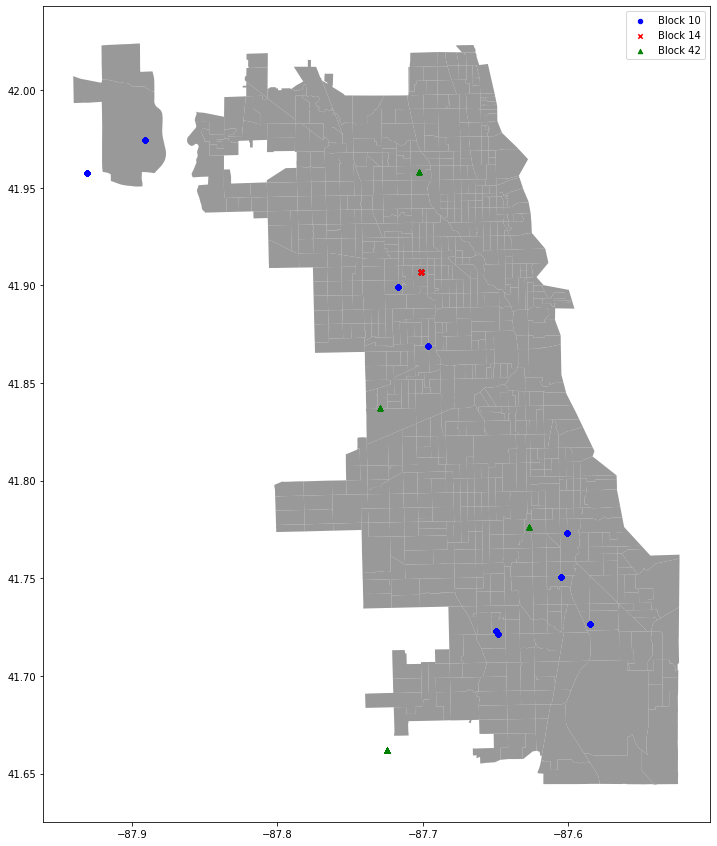

In [16]:
# Trying to visualize if block are specific areas

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[geo_df['Block'] == 10].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Block 10')
geo_df[geo_df['Block'] == 14].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Block 14')
geo_df[geo_df['Block'] == 42].plot(ax = ax, markersize = 20, color = 'green', marker = '^', label = 'Block 42')
plt.legend()

plt.savefig('data/charts/blocks.png')

Using the graph above, we can conclude that blocks are specific areas of the city and can't be used to map Mosquitos or Virus to a specific area of the city

### Virus Repartition

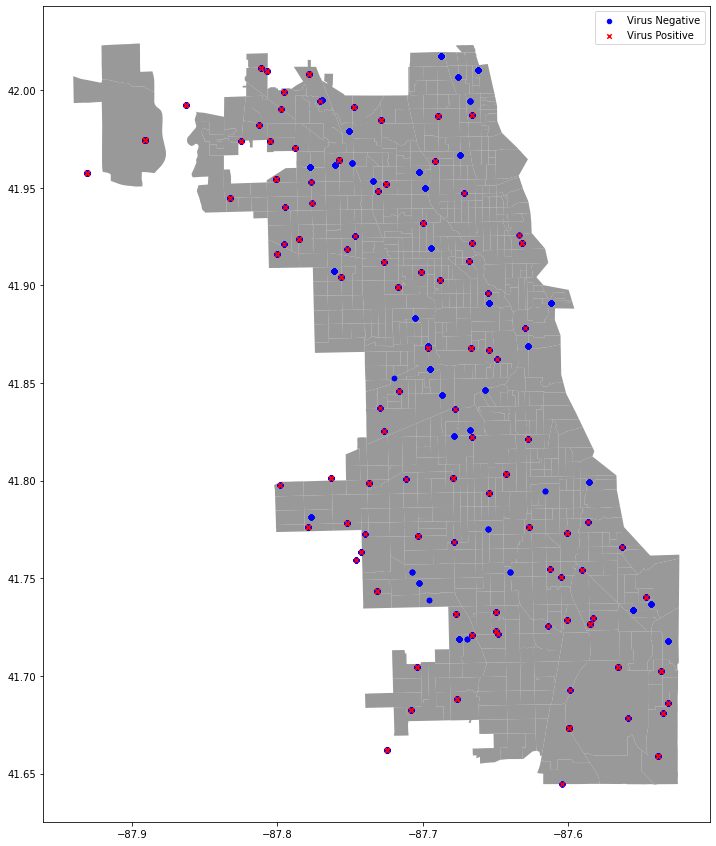

In [17]:
# See Global virus repartition

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[geo_df['WnvPresent'] == 0].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[geo_df['WnvPresent'] == 1].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.legend()

plt.savefig('data/charts/global_wnv.png')

From the graph above, we can see that Mosquitos carrying the virus have been identifed throughout the whole city and are not limited to a particular area of the city
This means that if we focus our spray efforts on only zone where positive mosquitos have been detected we would have to spray the whole city

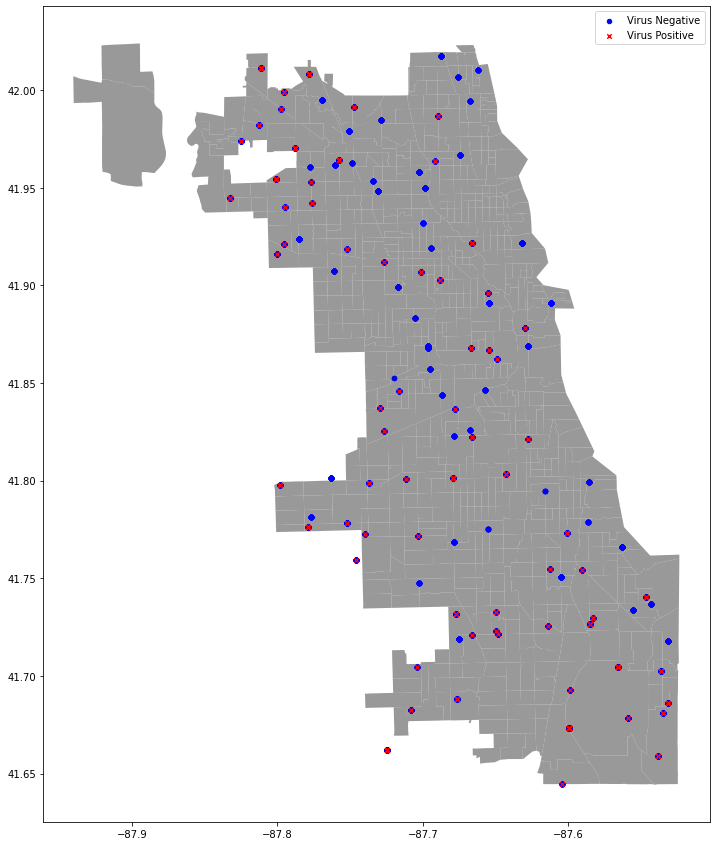

In [18]:
# See virus repartition for 2007

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2007)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2007)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.legend()

plt.savefig('data/charts/2007_wnv_repartition.png')

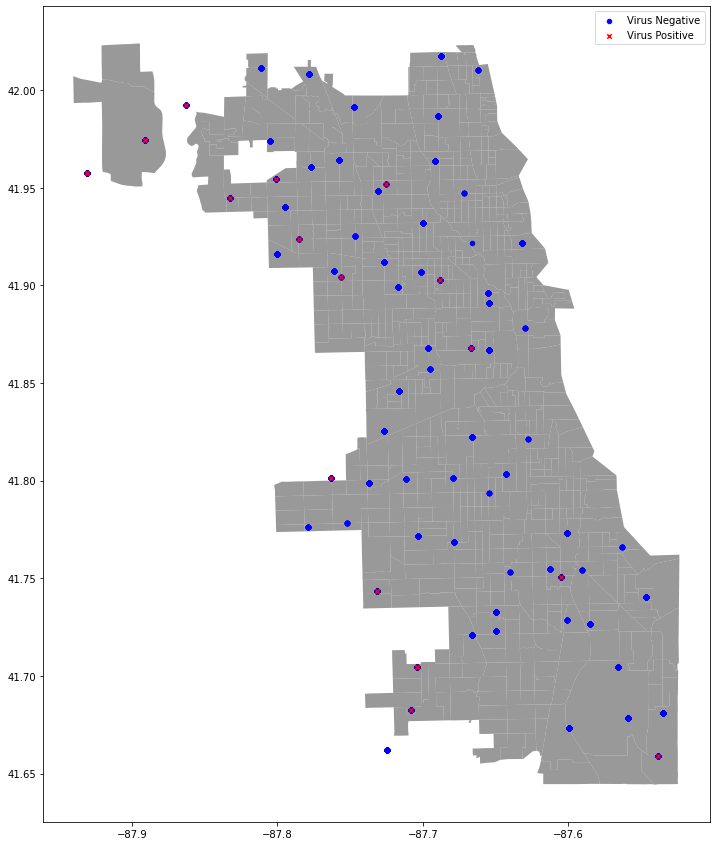

In [19]:
# See virus repartition for 2009

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2009)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2009)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.legend()

plt.savefig('data/charts/2009_virus_repartition.png')

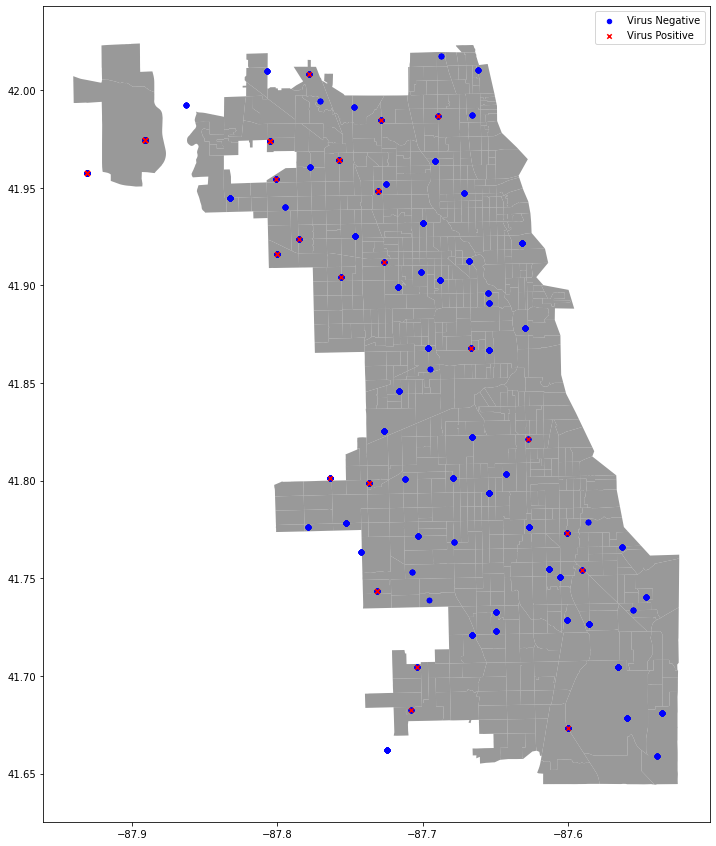

In [20]:
# See virus repartition for 2011

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2011)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2011)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.legend()

plt.savefig('data/charts/2011_virus_repartition.png')

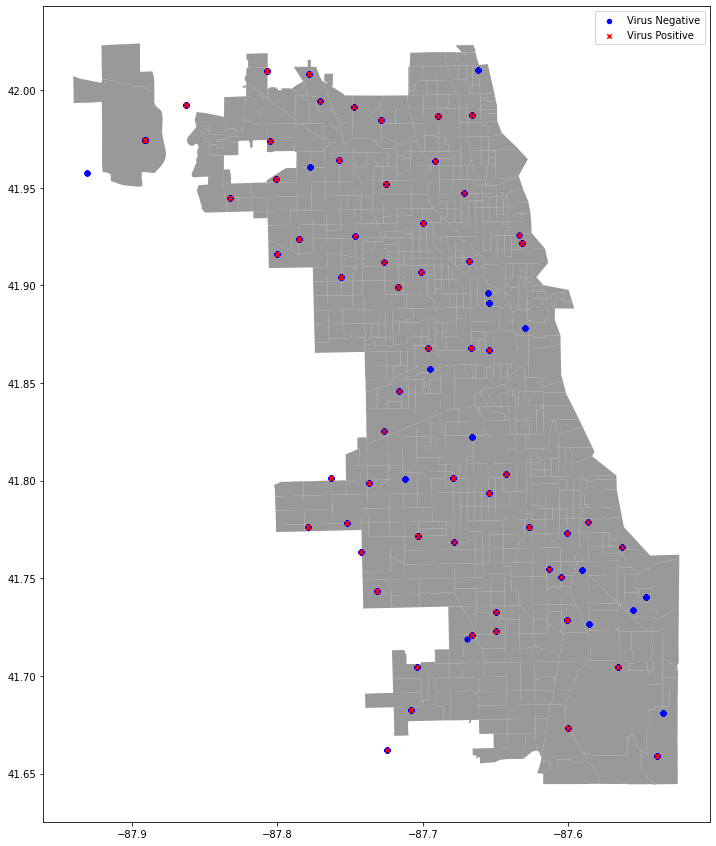

In [21]:
# See virus repartition for 2013

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 0) & (geo_df['year'] == 2013)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Negative')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2013)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Virus Positive')
plt.legend()

plt.savefig('data/charts/2013_virus_repartition.png')

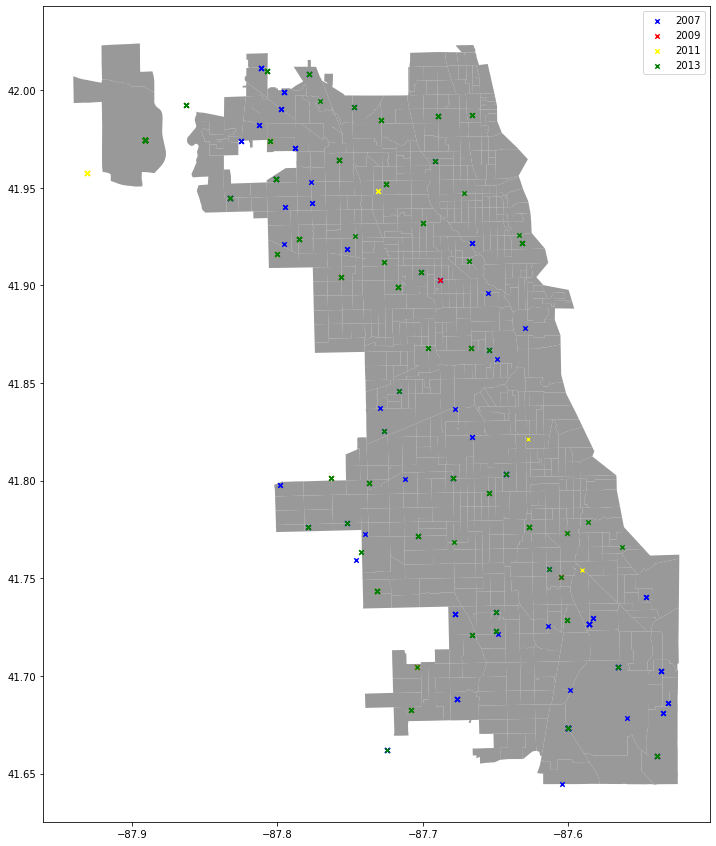

In [22]:
# Positive Virus repartition through the years

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2007)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = '2007')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2009)].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = '2009')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2011)].plot(ax = ax, markersize = 20, color = 'yellow', marker = 'x', label = '2011')
geo_df[(geo_df['WnvPresent'] == 1) & (geo_df['year'] == 2013)].plot(ax = ax, markersize = 20, color = 'green', marker = 'x', label = '2013')
plt.legend()

plt.savefig('data/charts/global_positive_virus.png')

Points are overlapping and we only see the highest layer (2013)

From the above graphs, we can see that the areas where mosquitos carrying the Wnv virus have been detected are consistent throughout the years. 

There doesn't seem to be a particular area where mosquitos are more likely to carry the virus.

### Mosquitos habitat and density

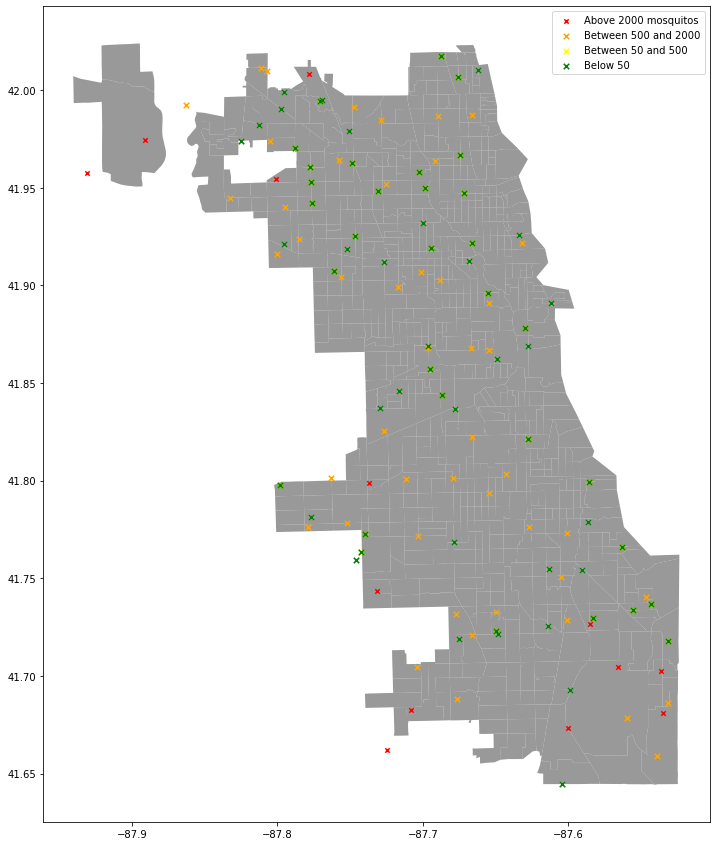

In [23]:
# Mosquitos density

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_mawnv[spray_mawnv['NumMosquitos'] >= 2000].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Above 2000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 2000) & (spray_mawnv['NumMosquitos'] >= 500)].plot(ax = ax, markersize = 30, color = 'orange', marker = 'x', label = 'Between 500 and 2000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'yellow', marker = 'x', label = 'Between 50 and 500')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'green', marker = 'x', label = 'Below 50')
plt.legend()

plt.savefig('data/charts/global_density.png')

Mosquitos are found throughout the city of Chicago, however, the number of mosquitos seem to vary from locations to other.

There are two areas with very high concentration of mosquitos.
* Lake Calumet and industrial South Deering area
* East side of O'Hare Airport

For area with a high concentration of mosquitos, they seem to be located in green and water point areas like:
* West O'Hare airport
* Wolf Lake - Eggers Grove
* Vet's Park
* Marian Byrnes Park and Natural area
* Wildwood park
* Park 601

or around green neighbourhoods of houses:
* Scottsdale
* Archer Heights
* South Mount Greenwood (close to Oak Hill Cemetery)

It seems that mosquito population seems to thrive in greener areas (Parks, Marshes) where body of permanent or semi-permanent water can be found. They are also found in high numbers in more industrial areas of the city (O'Hare airport and South Deering Area). 



### Spray efforts from the Chicago City

The city of Chicago has sprayed some areas of the city in both 2011 and 2013.

This spraying was done in order to reduce the population of mosquitos.

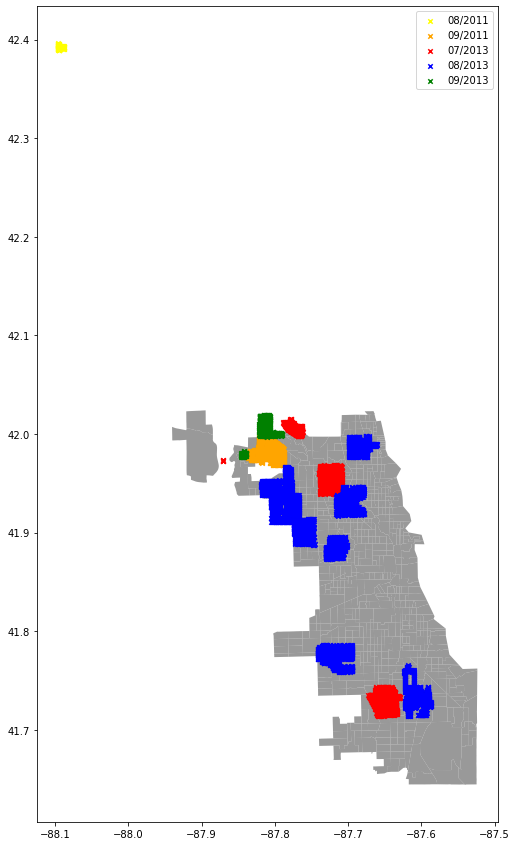

In [24]:
# Spray locations for 2011 and 2013

fig,ax = plt.subplots(figsize =(15,15))
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 8) ].plot(ax = ax, markersize = 20, color = 'yellow', marker = 'x', label = '08/2011')
spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'orange', marker = 'x', label = '09/2011')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 7) ].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = '07/2013')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 8) ].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = '08/2013')
spray_df[(spray_df['year'] == 2013) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'green', marker = 'x', label = '09/2013')
plt.legend()

plt.savefig('data/charts/global_spray.png')

It seems that during August 2011, the city has either sprayed an area far out of town or that the coordinates data provided is incorrect. In any case, we will not be making use of this data as it negatively impacts our map

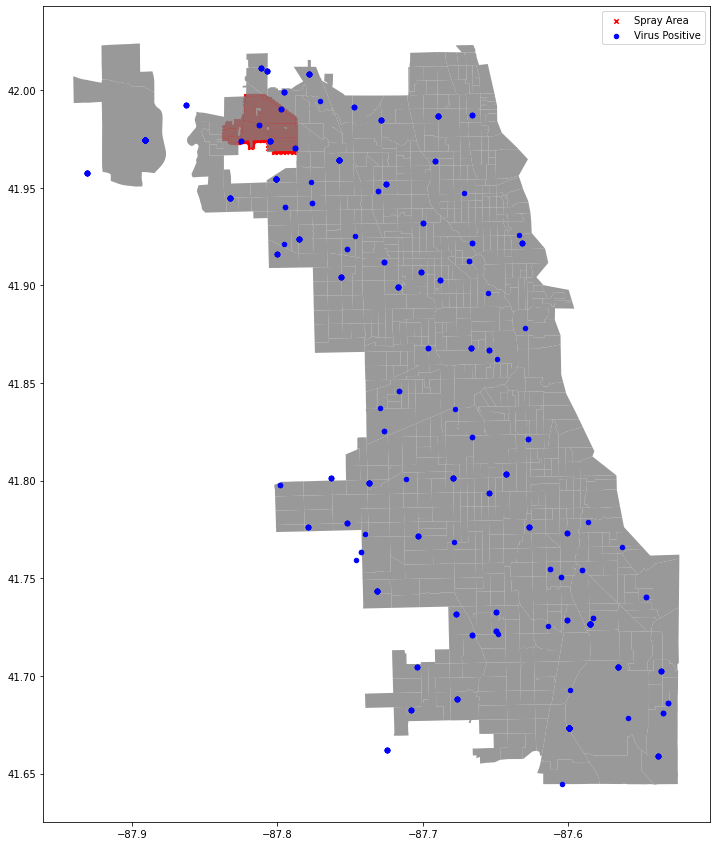

In [25]:
# Spray for September 2011 compared to positive virus locations

fig,ax = plt.subplots(figsize =(15,15))

spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9) ].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Spray Area')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
geo_df[geo_df['WnvPresent'] == 1].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Positive')
plt.legend()

plt.savefig('data/charts/2011_09_spray.png')

We can see that in September 2011, the city of chicago has concentrated it's spray effort on a limited area north west of the city.

This area correspond to Norwood Park and Orile Park. The most notable landmark in this area is the Ascension Resurection Medical Center.



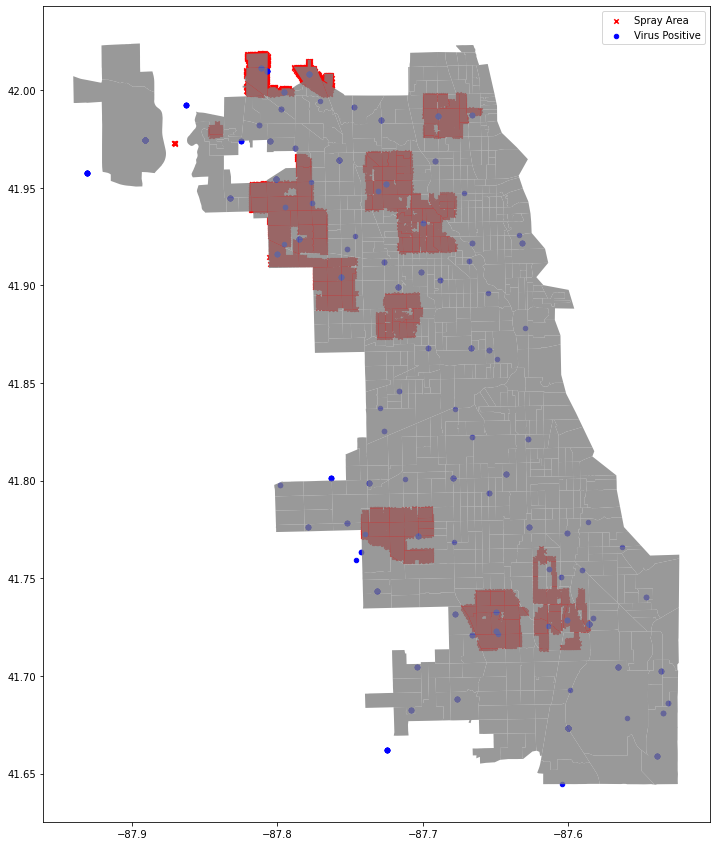

In [26]:
# Spray for 2013 compared to positive virus locations

fig,ax = plt.subplots(figsize =(15,15))

spray_df[spray_df['year'] == 2013].plot(ax = ax, markersize = 20, color = 'red', marker = 'x', label = 'Spray Area')
geo_df[geo_df['WnvPresent'] == 1].plot(ax = ax, markersize = 20, color = 'blue', marker = 'o', label = 'Virus Positive')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
plt.legend()

plt.savefig('data/charts/2013_spray.png')

During 2013 however, we can see that the city has intensified it's spray efforts and broadened it more lication throughout the city.

If we compare these locations to the city layout, we can see that all the areas sprayed are urban areas.

They have clearly avoided spraying parks and green areas

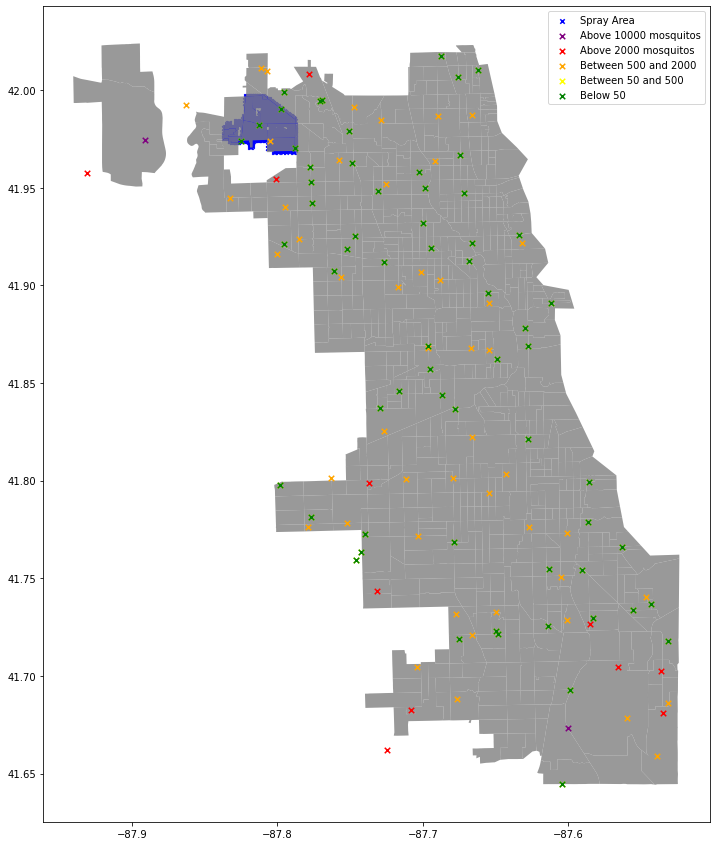

In [27]:
# Compare number of mosquitos with areas sprayed 2011

fig,ax = plt.subplots(figsize =(15,15))

spray_df[(spray_df['year'] == 2011) & (spray_df['month'] == 9)].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = 'Spray Area')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_mawnv[spray_mawnv['NumMosquitos'] >= 10000].plot(ax = ax, markersize = 30, color = 'purple', marker = 'x', label = 'Above 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 10000) & (spray_mawnv['NumMosquitos'] >= 2000)].plot(ax = ax, markersize = 30, color = 'red', marker = 'x', label = 'Above 2000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 2000) & (spray_mawnv['NumMosquitos'] >= 500)].plot(ax = ax, markersize = 30, color = 'orange', marker = 'x', label = 'Between 500 and 2000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'yellow', marker = 'x', label = 'Between 50 and 500')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'green', marker = 'x', label = 'Below 50')
plt.legend()

plt.savefig('data/charts/2011_spray_vs_density.png')

If we compare the areas sprayed with the areas with higher concentration of mosquitos, we can see that in 2011, the area that was sprayed was not among the highest mosquito density.

It was done in an area with relatively low concentration of mosquitos.

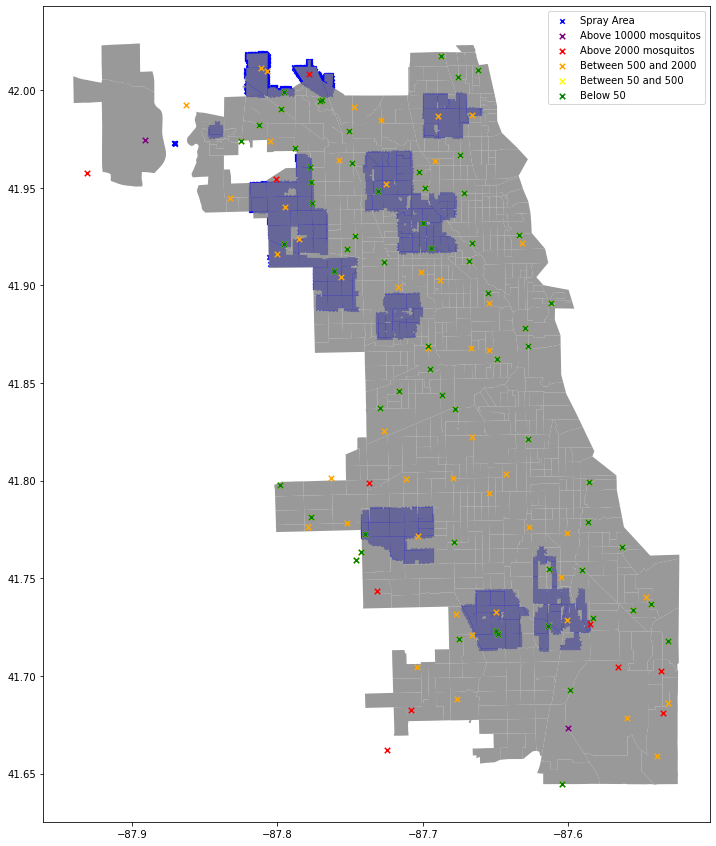

In [28]:
# Compare number of mosquitos with areas sprayed 2013

fig,ax = plt.subplots(figsize =(15,15))

spray_df[spray_df['year'] == 2013].plot(ax = ax, markersize = 20, color = 'blue', marker = 'x', label = 'Spray Area')
chicago.plot(ax =ax, alpha = 0.8, color='grey')
spray_mawnv[spray_mawnv['NumMosquitos'] >= 10000].plot(ax = ax, markersize = 30, color = 'purple', marker = 'x', label = 'Above 10000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 10000) & (spray_mawnv['NumMosquitos'] >= 2000)].plot(ax = ax, markersize = 30, color = 'red', marker = 'x', label = 'Above 2000 mosquitos')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 2000) & (spray_mawnv['NumMosquitos'] >= 500)].plot(ax = ax, markersize = 30, color = 'orange', marker = 'x', label = 'Between 500 and 2000')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'yellow', marker = 'x', label = 'Between 50 and 500')
spray_mawnv[(spray_mawnv['NumMosquitos'] < 500) & (spray_mawnv['NumMosquitos'] >= 50)].plot(ax = ax, markersize = 30, color = 'green', marker = 'x', label = 'Below 50')
plt.legend()

plt.savefig('data/charts/2013_spray_vs_density.png')

In [29]:
px.set_mapbox_access_token(MAPBOX_TOKEN)
fig = px.scatter_mapbox(train, lat = 'Latitude', lon  = 'Longitude',
                        size_max=15, zoom = 10)

fig.update_layout(title = 'Traps',
    autosize=False,
    width=500,
    height=700,)

fig.show()



In [30]:


fig = px.scatter_mapbox(spray, lat = 'Latitude', lon  = 'Longitude',
                     animation_frame="year",
                        size_max=15, zoom = 9)

fig.update_layout(
    title="Spray year wise",
        width=500,
    height=700,
)

fig.show()

In [31]:
# Display Mosquito concentration and relation with Virus

fig = px.scatter_mapbox(mosquito_areas_wnv, lat = 'Latitude', lon  = 'Longitude', color = 'WnvPresent',
                        #animation_frame='Date',
                        size = 'NumMosquitos', color_continuous_scale=px.colors.cyclical.IceFire,
                        hover_data = ['NumMosquitos', 'WnvPresent'],
                       zoom = 9)
fig.show()

In [32]:
# Effectiveness of spraying

fig = px.scatter_mapbox(spray, lat = 'Latitude', lon  = 'Longitude',#animation_frame = 'Date',
                        size_max=15, zoom = 9,color_discrete_sequence=["palegoldenrod"],  opacity = 0.5)

fig2 = px.scatter_mapbox(mosquito_areas_wnv, lat = 'Latitude', lon  = 'Longitude', color = 'WnvPresent',
                        size = 'NumMosquitos', color_continuous_scale=px.colors.cyclical.IceFire,
                        hover_data = ['NumMosquitos', 'WnvPresent'],
                       zoom = 9)

fig.add_trace(fig2.data[0],)

fig.update_layout( title = 'Spray - West Nile Virus and Mosquito clusters',
                width=500,
    height=700,)